In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

In [ ]:
from google.colab import drive
import os
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the function to create dataset
def create_dataset(folder_path):
    my_list = []
    for category in ['NORMAL', 'PNEUMONIA']:  # Iterate over the two classes
        category_path = os.path.join(folder_path, category)
        if os.path.exists(category_path):  # Ensure the category folder exists
            for file_name in os.listdir(category_path):
                file_path = os.path.join(category_path, file_name)
                # Ensure we're only adding image files
                if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])

# Dataset paths in Google Drive
dataset_dir = '/content/drive/My Drive/XAI_AA'  # Change this to your dataset path
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

# Create DataFrames for train, validation, and test datasets
train_df = create_dataset(train_dir)
val_df = create_dataset(val_dir)
test_df = create_dataset(test_dir)

# Convert labels to numeric: NORMAL -> 0, PNEUMONIA -> 1
train_df['label'] = train_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})
val_df['label'] = val_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})
test_df['label'] = test_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})

# Print dataset sizes
print(f"Train set size: {len(train_df)}, Validation set size: {len(val_df)}, Test set size: {len(test_df)}")


Mounted at /content/drive
Train set size: 5216, Validation set size: 16, Test set size: 624


In [ ]:
def count_categories(df, dataset_name):
    category_counts = df['label'].value_counts()
    print(f"{dataset_name} set:")
    print(f"  NORMAL: {category_counts.get(0, 0)}")
    print(f"  PNEUMONIA: {category_counts.get(1, 0)}")

# Count and display for train, validation, and test datasets
print("Image Counts per Category:")
count_categories(train_df, "Train")
count_categories(val_df, "Validation")
count_categories(test_df, "Test")

Image Counts per Category:
Train set:
  NORMAL: 1341
  PNEUMONIA: 3875
Validation set:
  NORMAL: 8
  PNEUMONIA: 8
Test set:
  NORMAL: 234
  PNEUMONIA: 390


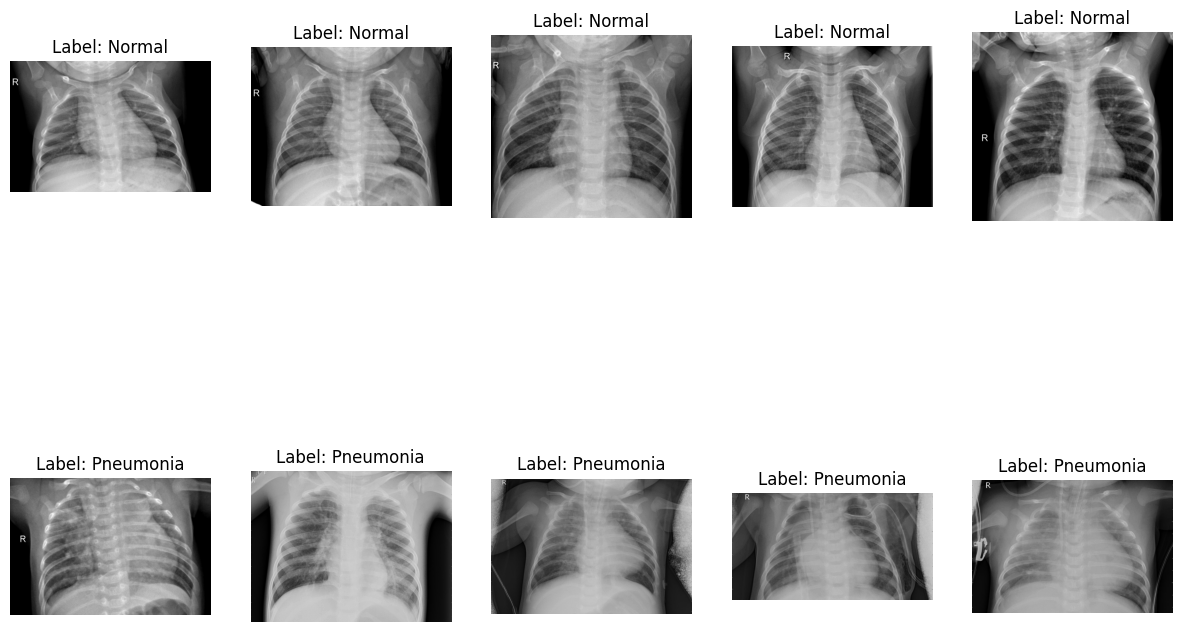

In [ ]:
def visualize_samples(df, n_samples=5):
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 10))

    # Visualize 5 NORMAL samples
    normal_samples = df[df['label'] == 0].iloc[:n_samples]
    for i in range(n_samples):
        img_path = normal_samples.iloc[i, 0]
        label = normal_samples.iloc[i, 1]
        image = Image.open(img_path).convert('L')  # Open in grayscale (original format)
        axes[0, i].imshow(image, cmap='gray')
        axes[0, i].set_title(f"Label: {['Normal', 'Pneumonia'][label]}")
        axes[0, i].axis('off')

    # Visualize 5 PNEUMONIA samples
    pneumonia_samples = df[df['label'] == 1].iloc[:n_samples]
    for i in range(n_samples):
        img_path = pneumonia_samples.iloc[i, 0]
        label = pneumonia_samples.iloc[i, 1]
        image = Image.open(img_path).convert('L')  # Open in grayscale (original format)
        axes[1, i].imshow(image, cmap='gray')
        axes[1, i].set_title(f"Label: {['Normal', 'Pneumonia'][label]}")
        axes[1, i].axis('off')

    plt.show()

# Show 5 samples from the training data
visualize_samples(train_df)

# Visualizing the class distribution
train_counts = train_df['label'].value_counts()
val_counts = val_df['label'].value_counts()
test_counts = test_df['label'].value_counts()


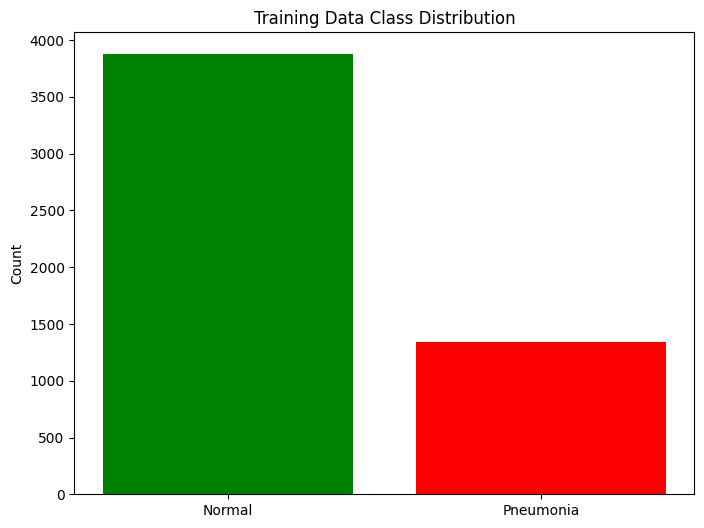

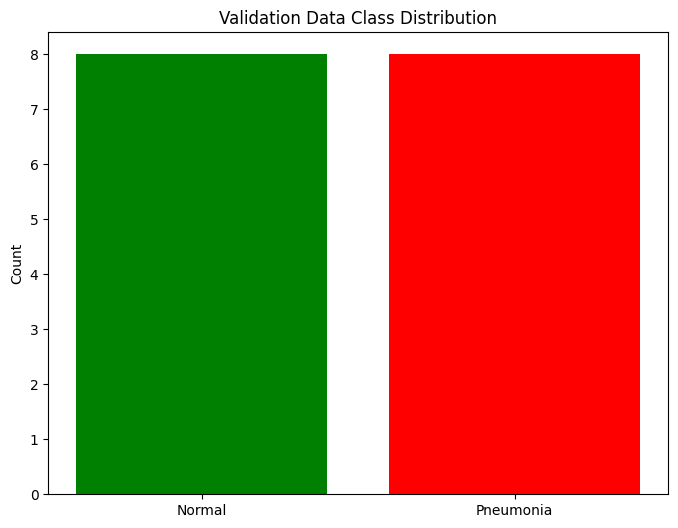

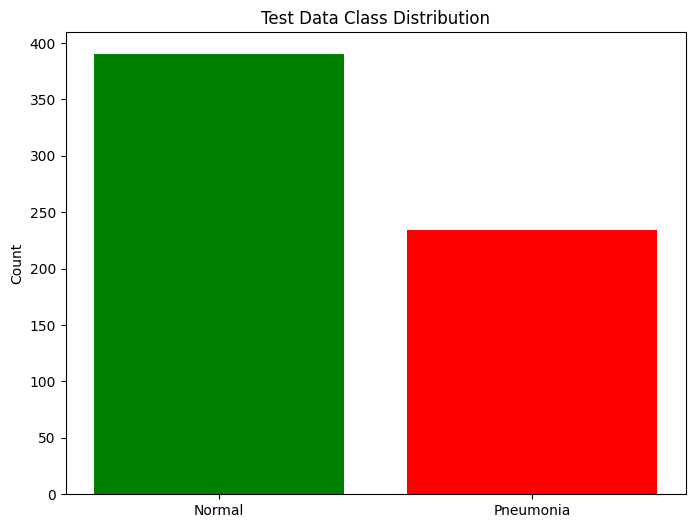

In [ ]:

plt.figure(figsize=(8, 6))
plt.bar(['Normal', 'Pneumonia'], train_counts, color=['green','red'])
plt.title("Training Data Class Distribution")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(['Normal', 'Pneumonia'], val_counts, color=['green','red'])
plt.title("Validation Data Class Distribution")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(['Normal', 'Pneumonia'], test_counts, color=['green','red'])
plt.title("Test Data Class Distribution")
plt.ylabel("Count")
plt.show()

In [ ]:
# Check for multi-GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to prepare model for multi-GPU usage
def prepare_model_for_multigpu(model):
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    model = model.to(device)
    return model

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

# Define transformations for training and validation

# For Custom CNN (Grayscale Input)
train_transform_cnn = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),  # Convert to grayscale (1 channel)
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),

])

val_transform_cnn = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

# For ResNet-18 (RGB Input)
train_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB (3 channels)
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB (3 channels)
    transforms.ToTensor(),
])

# Create datasets for both models
train_dataset_cnn = ImageDataset(train_df, transform=train_transform_cnn)
val_dataset_cnn = ImageDataset(val_df, transform=val_transform_cnn)

train_dataset_resnet = ImageDataset(train_df, transform=train_transform_resnet)
val_dataset_resnet = ImageDataset(val_df, transform=val_transform_resnet)

# DataLoader
batch_size = 32
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False)

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=batch_size, shuffle=True)
val_loader_resnet = DataLoader(val_dataset_resnet, batch_size=batch_size, shuffle=False)



In [ ]:
# Define Custom CNN Model (from scratch)
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1 input channel for grayscale
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)  # Pooling layer
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
model_from_scratch = CustomCNN().to(device)

model_from_scratch = prepare_model_for_multigpu(model_from_scratch)

In [ ]:
def train_model_with_history(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate validation loss and accuracy
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print results for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Define loss function and optimizer for Custom CNN
criterion = nn.CrossEntropyLoss()
optimizer_from_scratch = optim.Adam(model_from_scratch.parameters(), lr=0.001)

In [ ]:
# Train the Custom CNN Model (from scratch)
print("Training Custom CNN Model (from scratch)...")
train_losses_cnn, val_losses_cnn, train_accuracies_cnn, val_accuracies_cnn = train_model_with_history(
    model_from_scratch, train_loader_cnn, val_loader_cnn, criterion, optimizer_from_scratch, num_epochs=10
)

Training Custom CNN Model (from scratch)...
Epoch [1/10] Train Loss: 0.1592, Train Acc: 95.84% | Val Loss: 0.2935, Val Acc: 87.50%
Epoch [2/10] Train Loss: 0.1379, Train Acc: 96.55% | Val Loss: 0.4142, Val Acc: 81.25%
Epoch [3/10] Train Loss: 0.1186, Train Acc: 96.88% | Val Loss: 0.4490, Val Acc: 81.25%
Epoch [4/10] Train Loss: 0.0987, Train Acc: 97.47% | Val Loss: 0.1225, Val Acc: 93.75%
Epoch [5/10] Train Loss: 0.0963, Train Acc: 97.35% | Val Loss: 0.0817, Val Acc: 100.00%
Epoch [6/10] Train Loss: 0.0833, Train Acc: 97.53% | Val Loss: 0.4396, Val Acc: 81.25%
Epoch [7/10] Train Loss: 0.0709, Train Acc: 98.03% | Val Loss: 0.1791, Val Acc: 93.75%
Epoch [8/10] Train Loss: 0.0717, Train Acc: 98.16% | Val Loss: 0.2280, Val Acc: 93.75%
Epoch [9/10] Train Loss: 0.0558, Train Acc: 98.70% | Val Loss: 0.1093, Val Acc: 100.00%
Epoch [10/10] Train Loss: 0.0508, Train Acc: 98.68% | Val Loss: 0.0520, Val Acc: 100.00%


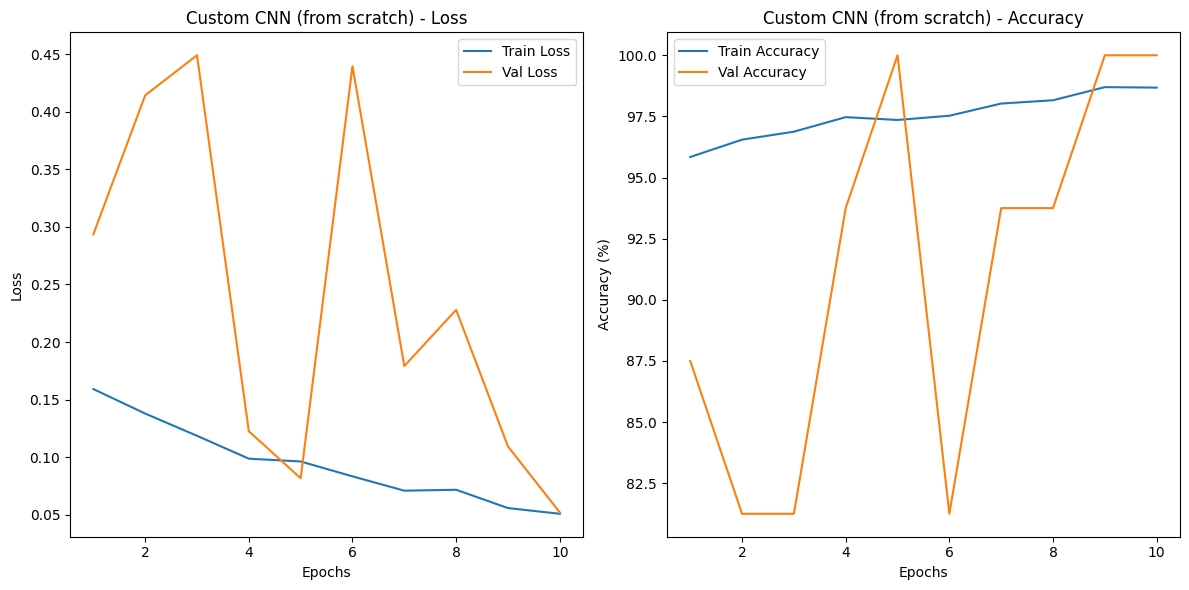

In [ ]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot results for Custom CNN (from scratch)
plot_training_history(train_losses_cnn, val_losses_cnn, train_accuracies_cnn, val_accuracies_cnn, "Custom CNN (from scratch)")


LOading predefined model

In [ ]:
# Load pretrained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)  # Modify for binary classification
resnet18 = prepare_model_for_multigpu(resnet18)  # Apply multi-GPU

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


In [ ]:
# Define optimizer for ResNet-18
optimizer_resnet = optim.Adam(resnet18.parameters(), lr=0.001)

# Train the Pretrained ResNet-18 Model
print("Training Pretrained ResNet-18 Model...")
train_losses_resnet, val_losses_resnet, train_accuracies_resnet, val_accuracies_resnet = train_model_with_history(
    resnet18, train_loader_resnet, val_loader_resnet, criterion, optimizer_resnet, num_epochs=10
)

Training Pretrained ResNet-18 Model...
Epoch [1/10] Train Loss: 0.1228, Train Acc: 95.49% | Val Loss: 0.5185, Val Acc: 75.00%
Epoch [2/10] Train Loss: 0.0633, Train Acc: 97.76% | Val Loss: 6.0320, Val Acc: 62.50%
Epoch [3/10] Train Loss: 0.0604, Train Acc: 97.87% | Val Loss: 1.8566, Val Acc: 62.50%
Epoch [4/10] Train Loss: 0.0503, Train Acc: 98.18% | Val Loss: 5.0621, Val Acc: 56.25%
Epoch [5/10] Train Loss: 0.0531, Train Acc: 97.87% | Val Loss: 0.1365, Val Acc: 93.75%
Epoch [6/10] Train Loss: 0.0351, Train Acc: 98.54% | Val Loss: 0.3976, Val Acc: 81.25%
Epoch [7/10] Train Loss: 0.0425, Train Acc: 98.45% | Val Loss: 0.4654, Val Acc: 87.50%
Epoch [8/10] Train Loss: 0.0287, Train Acc: 98.96% | Val Loss: 1.9990, Val Acc: 62.50%
Epoch [9/10] Train Loss: 0.0354, Train Acc: 98.81% | Val Loss: 3.2796, Val Acc: 50.00%
Epoch [10/10] Train Loss: 0.0385, Train Acc: 98.52% | Val Loss: 0.2458, Val Acc: 93.75%


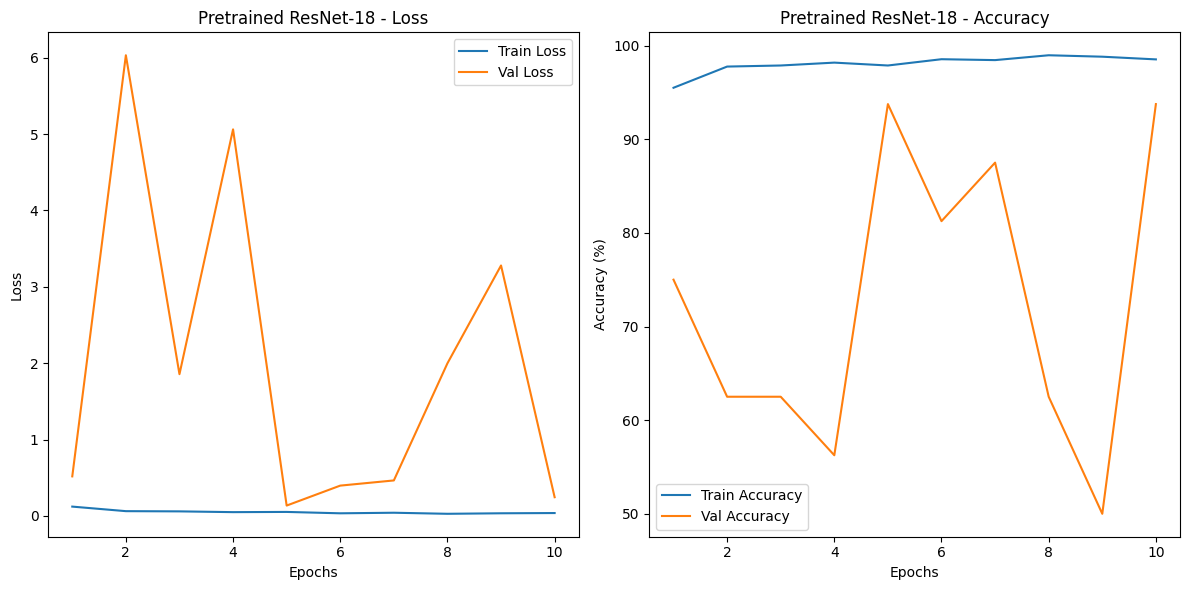

In [ ]:
# Plot training and validation loss/accuracy for ResNet-18
plot_training_history(train_losses_resnet, val_losses_resnet, train_accuracies_resnet, val_accuracies_resnet, "Pretrained ResNet-18")

In [ ]:
# Create Dataset and DataLoader for Test Set (Custom CNN)
test_transform_cnn = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),  # Keep image as grayscale (1 channel)
    transforms.ToTensor(),
])

test_dataset_cnn = ImageDataset(test_df, transform=test_transform_cnn)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=32, shuffle=False)

In [ ]:
 #Create Dataset and DataLoader for Test Set (ResNet-18)
test_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (RGB)
    transforms.ToTensor(),
])

test_dataset_resnet = ImageDataset(test_df, transform=test_transform_resnet)
test_loader_resnet = DataLoader(test_dataset_resnet, batch_size=32, shuffle=False)

In [ ]:
# Function to evaluate the model and return predictions, true labels, and scores
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Evaluate Custom CNN from Scratch on Test Set
y_true_cnn, y_pred_cnn = evaluate_model(model_from_scratch, test_loader_cnn)

# Evaluate Pretrained ResNet18 on Test Set
y_true_resnet, y_pred_resnet = evaluate_model(resnet18, test_loader_resnet)

# Print accuracy for both models
accuracy_cnn = accuracy_score(y_true_cnn, y_pred_cnn)
accuracy_resnet = accuracy_score(y_true_resnet, y_pred_resnet)

print(f"Accuracy of Custom CNN from Scratch: {accuracy_cnn:.4f}")
print(f"Accuracy of Pretrained ResNet18: {accuracy_resnet:.4f}")

Accuracy of Custom CNN from Scratch: 0.7580
Accuracy of Pretrained ResNet18: 0.8173


Custom CNN from Scratch:


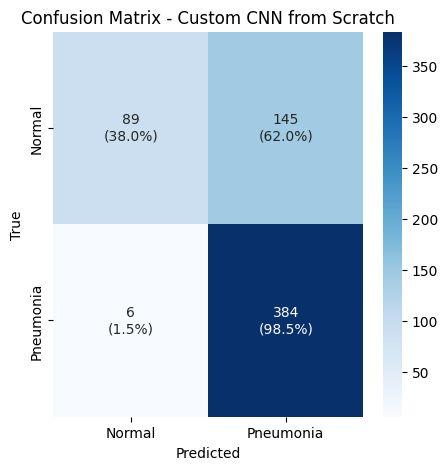

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.38      0.54       234
           1       0.73      0.98      0.84       390

    accuracy                           0.76       624
   macro avg       0.83      0.68      0.69       624
weighted avg       0.81      0.76      0.73       624

Pretrained ResNet18:


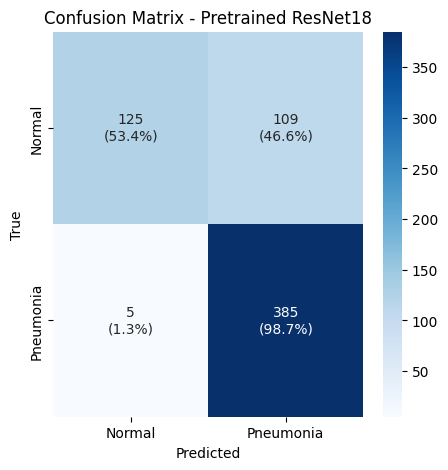

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.53      0.69       234
           1       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624



In [ ]:
# Function to plot confusion matrix with percentages
def plot_confusion_matrix_with_percentages(cm, model_name):
    plt.figure(figsize=(5, 5))
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Annotate with both raw numbers and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percentage[i, j]:.1f}%)"

    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Scores and Confusion Matrix for Custom CNN from Scratch
print("Custom CNN from Scratch:")
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
plot_confusion_matrix_with_percentages(cm_cnn, "Custom CNN from Scratch")
print("Classification Report:\n", classification_report(y_true_cnn, y_pred_cnn))

# Scores and Confusion Matrix for Pretrained ResNet18
print("Pretrained ResNet18:")
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
plot_confusion_matrix_with_percentages(cm_resnet, "Pretrained ResNet18")
print("Classification Report:\n", classification_report(y_true_resnet, y_pred_resnet))


Balanced Predictions from Custom CNN:


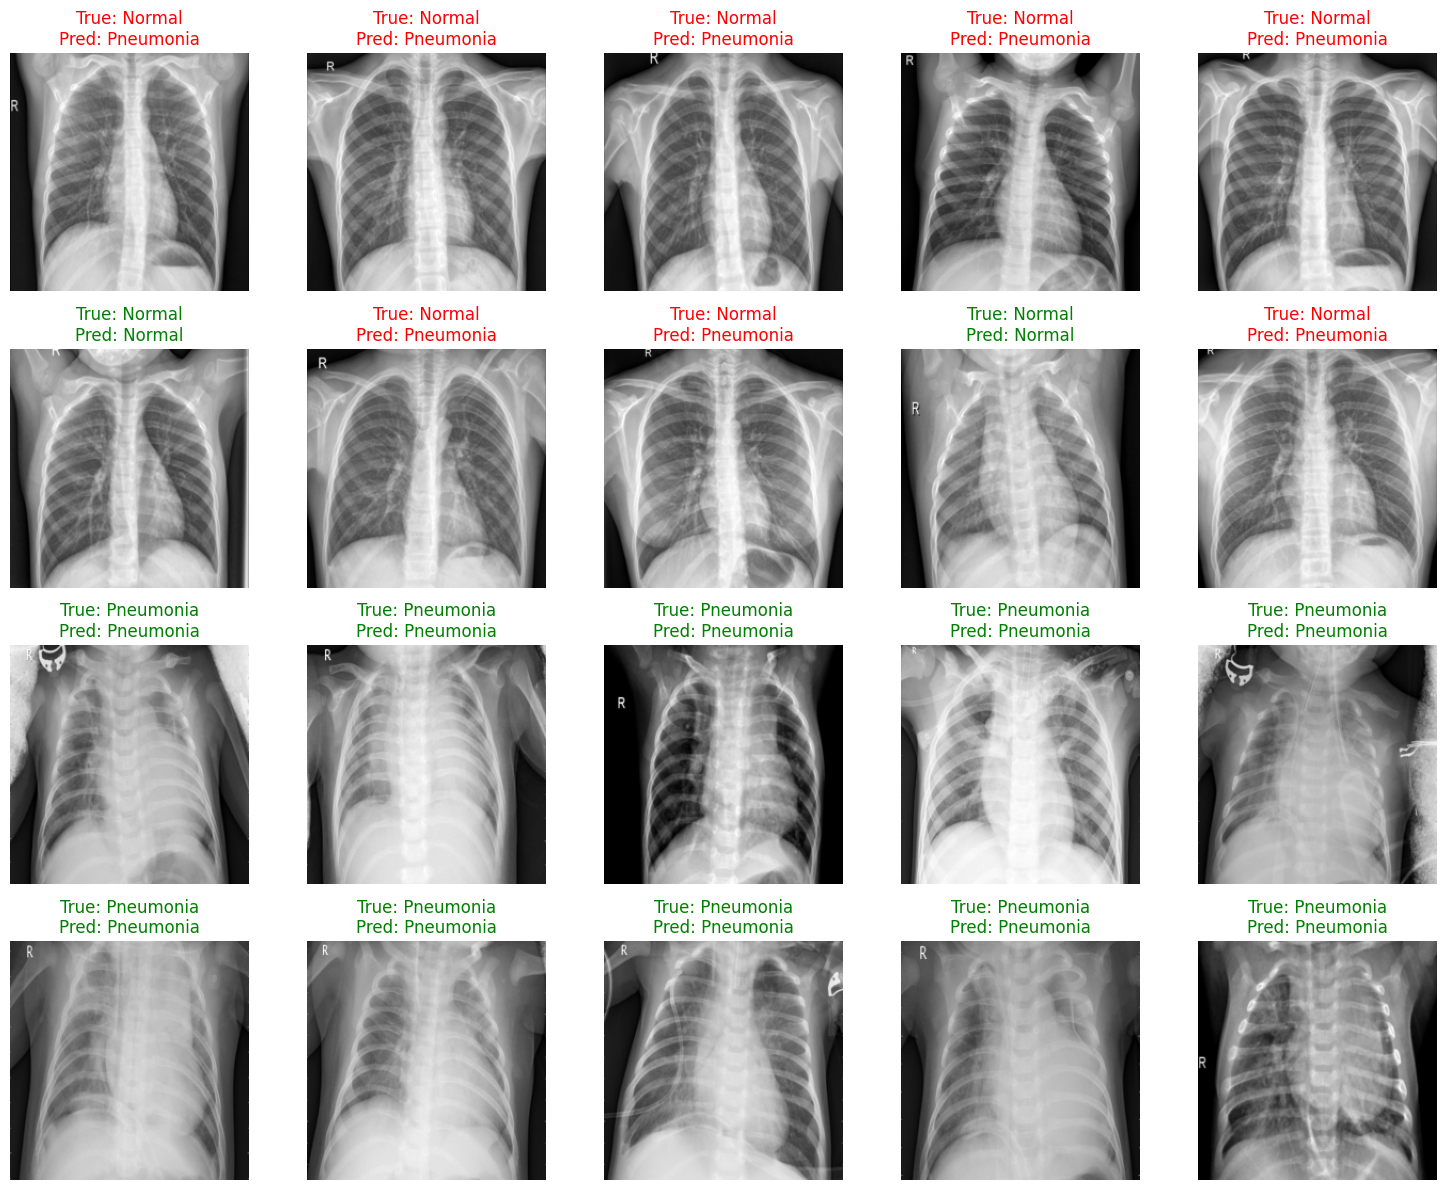

Balanced Predictions from Pretrained ResNet18:


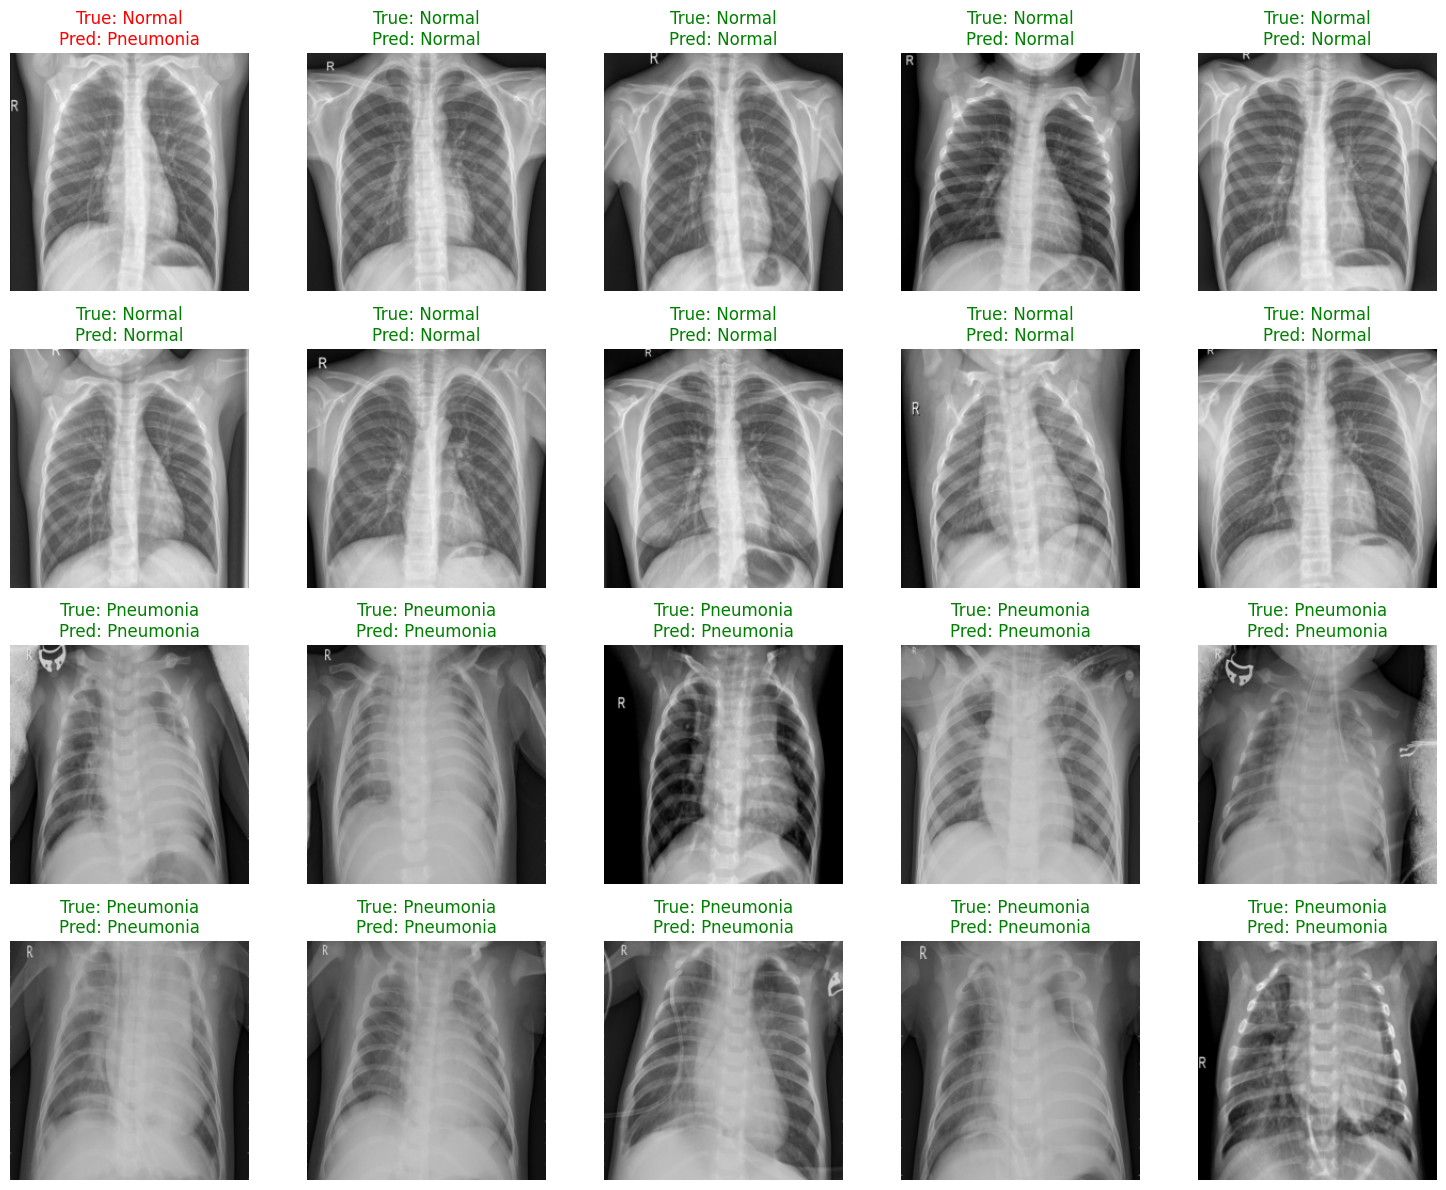

In [ ]:
def show_balanced_predictions(model, loader, class_names, num_normal=10, num_pneumonia=10):
    """
    Display images with balanced true labels (Normal and Pneumonia).
    Highlight incorrect predictions in red.
    """
    model.eval()  # Set the model to evaluation mode
    normal_images = []
    pneumonia_images = []

    # Gather predictions for "Normal" and "Pneumonia" separately
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            for i in range(images.size(0)):
                # Convert image tensor to numpy array for display
                image = images[i].cpu().numpy().transpose(1, 2, 0)
                if image.shape[-1] == 1:  # Grayscale image
                    image = image.squeeze(-1)

                true_label = labels[i].item()
                pred_label = predictions[i].item()
                label_dict = {
                    "image": image,
                    "true_label": class_names[true_label],
                    "pred_label": class_names[pred_label],
                    "correct": true_label == pred_label,
                }

                # Collect images based on true labels
                if true_label == 0 and len(normal_images) < num_normal:
                    normal_images.append(label_dict)
                elif true_label == 1 and len(pneumonia_images) < num_pneumonia:
                    pneumonia_images.append(label_dict)

            # Break the loop if we have enough images
            if len(normal_images) >= num_normal and len(pneumonia_images) >= num_pneumonia:
                break

    # Combine images for display
    images_to_display = normal_images + pneumonia_images
    rows, cols = 4, 5  # Grid size
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(images_to_display):
            img_dict = images_to_display[idx]
            image = img_dict["image"]
            true_label = img_dict["true_label"]
            pred_label = img_dict["pred_label"]
            correct = img_dict["correct"]

            # Title with green for correct, red for incorrect
            title_color = "green" if correct else "red"
            ax.imshow(image, cmap="gray" if image.ndim == 2 else None)
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
            ax.axis("off")
        else:
            ax.axis("off")  # Empty cells

    plt.tight_layout()
    plt.show()

# Show predictions for Custom CNN
print("Balanced Predictions from Custom CNN:")
show_balanced_predictions(model_from_scratch, test_loader_cnn, class_names=["Normal", "Pneumonia"], num_normal=10, num_pneumonia=10)

# Show predictions for Pretrained ResNet18
print("Balanced Predictions from Pretrained ResNet18:")
show_balanced_predictions(resnet18, test_loader_resnet, class_names=["Normal", "Pneumonia"], num_normal=10, num_pneumonia=10)


model 3 pretrained vgg16

In [ ]:
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze the feature extractor layers
for param in vgg16.features.parameters():
    param.requires_grad = False  # Freeze the weights in the feature extractor part

# Modify the classifier for binary classification
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=2)  # 2 classes (Normal, Pneumonia)

# Move the model to GPU if available
vgg16 = prepare_model_for_multigpu(vgg16)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 166MB/s]


In [ ]:
# Define Dataset class
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
# Define transformations for training and validation for VGG16 (RGB Input)
train_transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pre-trained VGG normalization
])

val_transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pre-trained VGG normalization
])

In [ ]:
train_dataset_vgg = ImageDataset(train_df, transform=train_transform_vgg)
val_dataset_vgg = ImageDataset(val_df, transform=val_transform_vgg)

# DataLoader for VGG16
batch_size = 32
train_loader_vgg = DataLoader(train_dataset_vgg, batch_size=batch_size, shuffle=True)
val_loader_vgg = DataLoader(val_dataset_vgg, batch_size=batch_size, shuffle=False)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(vgg16.parameters(), lr=0.001)

In [ ]:
def train_model_vgg(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    # History lists for plotting
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate training loss and accuracy
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate validation loss and accuracy
        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = 100 * val_correct / val_total

        # Save history for plotting
        train_loss_history.append(epoch_loss)
        val_loss_history.append(val_epoch_loss)
        train_acc_history.append(epoch_acc)
        val_acc_history.append(val_epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history


In [ ]:
 #Train the VGG16 model
train_loss_history_vgg, val_loss_history_vgg, train_acc_history_vgg, val_acc_history_vgg = train_model_vgg(
    vgg16, train_loader_vgg, val_loader_vgg, criterion, optimizer_vgg, num_epochs=10
)

Epoch [1/10] Train Loss: 0.4143, Train Acc: 92.77% | Val Loss: 0.0000, Val Acc: 100.00%
Epoch [2/10] Train Loss: 0.4484, Train Acc: 96.47% | Val Loss: 0.0000, Val Acc: 100.00%
Epoch [3/10] Train Loss: 0.3204, Train Acc: 97.26% | Val Loss: 0.8129, Val Acc: 81.25%
Epoch [4/10] Train Loss: 0.1293, Train Acc: 98.47% | Val Loss: 0.0068, Val Acc: 100.00%
Epoch [5/10] Train Loss: 0.1438, Train Acc: 98.41% | Val Loss: 0.0000, Val Acc: 100.00%
Epoch [6/10] Train Loss: 0.1385, Train Acc: 98.75% | Val Loss: 0.0000, Val Acc: 100.00%
Epoch [7/10] Train Loss: 0.1305, Train Acc: 98.73% | Val Loss: 0.0003, Val Acc: 100.00%
Epoch [8/10] Train Loss: 0.1335, Train Acc: 98.91% | Val Loss: 0.0000, Val Acc: 100.00%
Epoch [9/10] Train Loss: 0.1579, Train Acc: 98.95% | Val Loss: 0.0000, Val Acc: 100.00%
Epoch [10/10] Train Loss: 0.2703, Train Acc: 98.79% | Val Loss: 0.0053, Val Acc: 100.00%


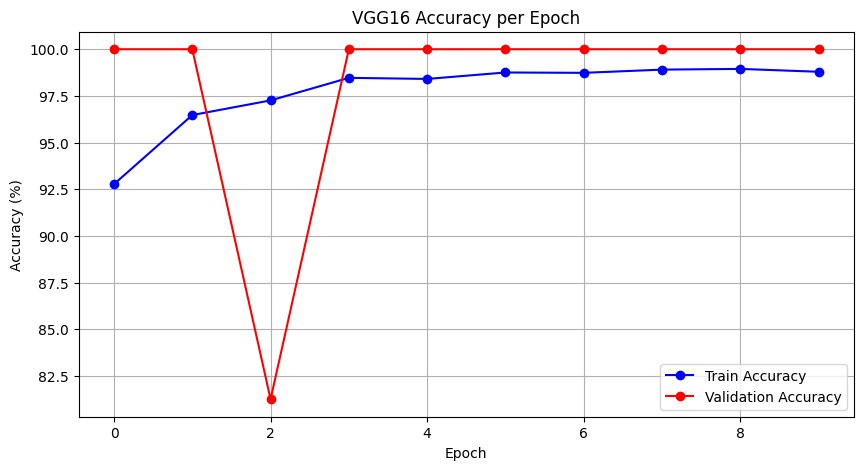

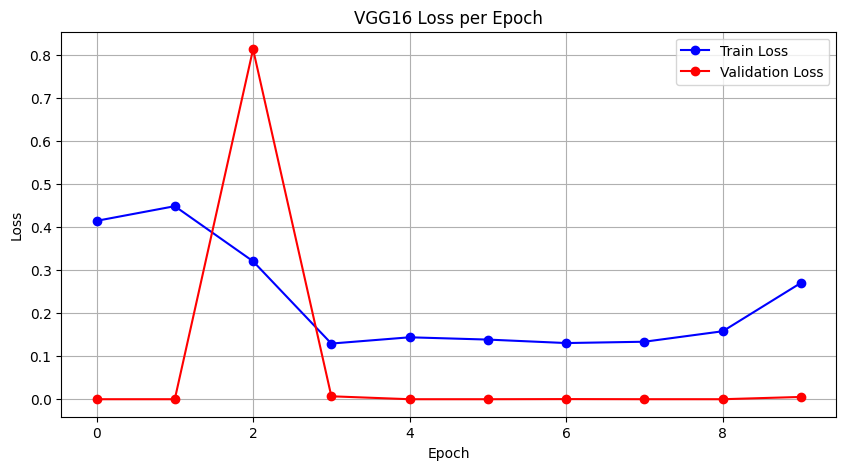

In [ ]:
# Plot accuracy for VGG16
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history_vgg, label='Train Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(val_acc_history_vgg, label='Validation Accuracy', color='red', linestyle='-', marker='o')
plt.title('VGG16 Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss for VGG16
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history_vgg, label='Train Loss', color='blue', linestyle='-', marker='o')
plt.plot(val_loss_history_vgg, label='Validation Loss', color='red', linestyle='-', marker='o')
plt.title('VGG16 Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# For VGG (RGB Input)
test_transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

In [ ]:
test_dataset_vgg = ImageDataset(test_df, transform=test_transform_vgg)

In [ ]:
test_loader_vgg = DataLoader(test_dataset_vgg, batch_size=32, shuffle=False)

In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_loss /= len(test_loader)

    print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {accuracy:.2f}%')

    return y_true, y_pred

# Evaluate the VGG model on the test set
y_true_vgg, y_pred_vgg = evaluate_model(vgg16, test_loader_vgg, criterion)

Test Loss: 23.1044 | Test Accuracy: 63.30%


In [ ]:
# Function to evaluate the model and return predictions, true labels, and scores
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

In [ ]:
# Evaluate Custom CNN from Scratch on Test Set
y_true_cnn, y_pred_cnn = evaluate_model(model_from_scratch, test_loader_cnn)

# Evaluate Pretrained ResNet18 on Test Set
y_true_resnet, y_pred_resnet = evaluate_model(resnet18, test_loader_resnet)

# Evaluate Pretrained VGG on Test Set
y_true_vgg, y_pred_vgg = evaluate_model(vgg16, test_loader_vgg)

In [ ]:
# Calculate accuracy for each model
accuracy_cnn = accuracy_score(y_true_cnn, y_pred_cnn)
accuracy_resnet = accuracy_score(y_true_resnet, y_pred_resnet)
accuracy_vgg = accuracy_score(y_true_vgg, y_pred_vgg)

# Print accuracy for all models
print(f"Accuracy of Custom CNN from Scratch: {accuracy_cnn:.4f}")
print(f"Accuracy of Pretrained ResNet18: {accuracy_resnet:.4f}")
print(f"Accuracy of Pretrained VGG: {accuracy_vgg:.4f}")

Accuracy of Custom CNN from Scratch: 0.7580
Accuracy of Pretrained ResNet18: 0.8173
Accuracy of Pretrained VGG: 0.6330


In [ ]:
# Function to plot confusion matrix with percentages
def plot_confusion_matrix_with_percentages(cm, model_name):
    plt.figure(figsize=(5, 5))
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

    # Annotate with both raw numbers and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percentage[i, j]:.1f}%)"

    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Custom CNN from Scratch:


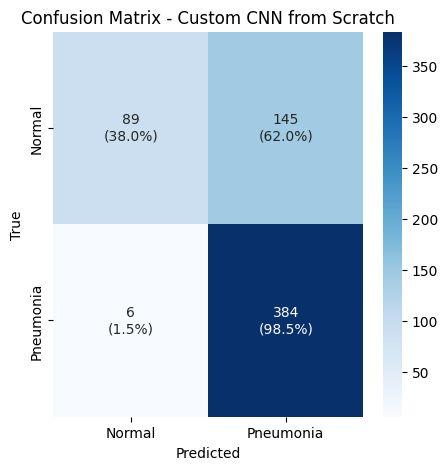

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.38      0.54       234
           1       0.73      0.98      0.84       390

    accuracy                           0.76       624
   macro avg       0.83      0.68      0.69       624
weighted avg       0.81      0.76      0.73       624

Pretrained ResNet18:


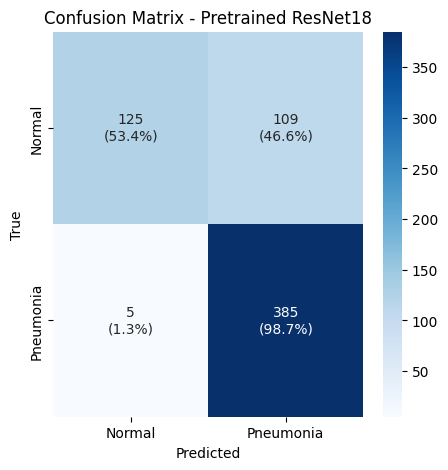

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.53      0.69       234
           1       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624

Pretrained VGG:


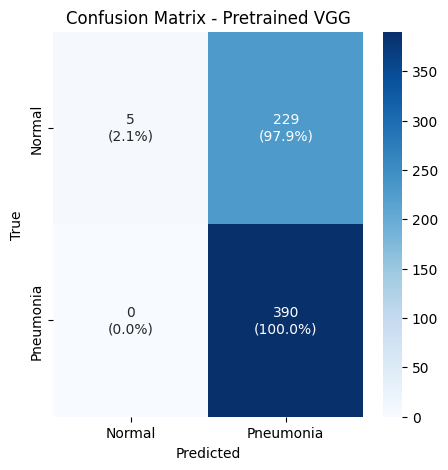

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.02      0.04       234
           1       0.63      1.00      0.77       390

    accuracy                           0.63       624
   macro avg       0.82      0.51      0.41       624
weighted avg       0.77      0.63      0.50       624



In [ ]:
# Scores and Confusion Matrix for Custom CNN from Scratch
print("Custom CNN from Scratch:")
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
plot_confusion_matrix_with_percentages(cm_cnn, "Custom CNN from Scratch")
print("Classification Report:\n", classification_report(y_true_cnn, y_pred_cnn))

# Scores and Confusion Matrix for Pretrained ResNet18
print("Pretrained ResNet18:")
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
plot_confusion_matrix_with_percentages(cm_resnet, "Pretrained ResNet18")
print("Classification Report:\n", classification_report(y_true_resnet, y_pred_resnet))

# Scores and Confusion Matrix for Pretrained VGG
print("Pretrained VGG:")
cm_vgg = confusion_matrix(y_true_vgg, y_pred_vgg)
plot_confusion_matrix_with_percentages(cm_vgg, "Pretrained VGG")
print("Classification Report:\n", classification_report(y_true_vgg, y_pred_vgg))

In [ ]:
# Calculate Precision, Recall, and F1 for all models
precision_cnn = precision_score(y_true_cnn, y_pred_cnn)
recall_cnn = recall_score(y_true_cnn, y_pred_cnn)
f1_cnn = f1_score(y_true_cnn, y_pred_cnn)

precision_resnet = precision_score(y_true_resnet, y_pred_resnet)
recall_resnet = recall_score(y_true_resnet, y_pred_resnet)
f1_resnet = f1_score(y_true_resnet, y_pred_resnet)

precision_vgg = precision_score(y_true_vgg, y_pred_vgg)
recall_vgg = recall_score(y_true_vgg, y_pred_vgg)
f1_vgg = f1_score(y_true_vgg, y_pred_vgg)

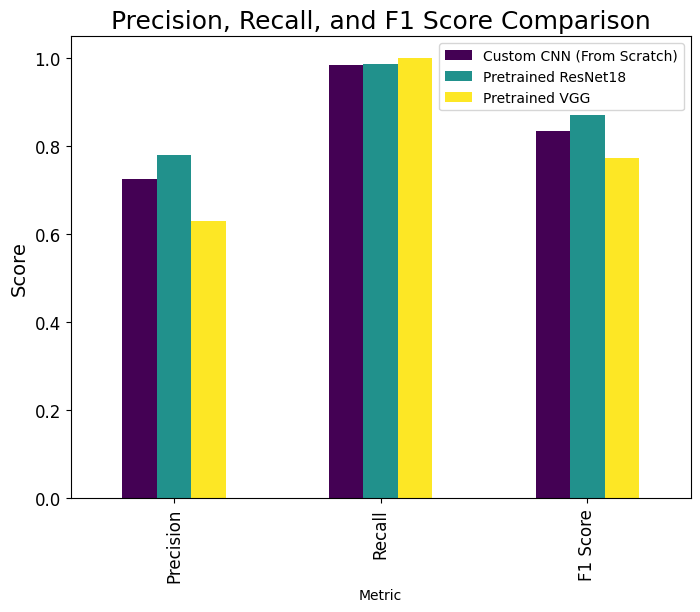

In [ ]:
# Comparison DataFrame for Precision, Recall, F1 Score
scores_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Custom CNN (From Scratch)': [precision_cnn, recall_cnn, f1_cnn],
    'Pretrained ResNet18': [precision_resnet, recall_resnet, f1_resnet],
    'Pretrained VGG': [precision_vgg, recall_vgg, f1_vgg]
})

scores_df.set_index('Metric', inplace=True)
scores_df.plot(kind='bar', figsize=(8, 6), colormap='viridis')
plt.title("Precision, Recall, and F1 Score Comparison", fontsize=18)
plt.ylabel("Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


<ipython-input-46-2d28128503fe>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="viridis")


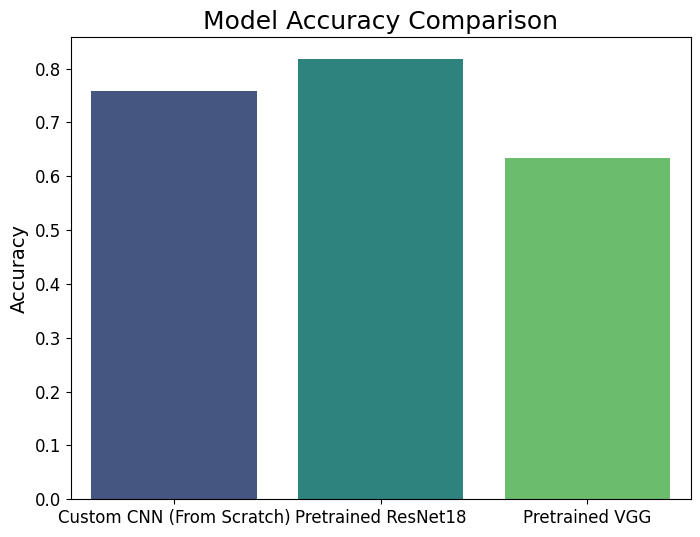

In [ ]:
# Comparison of Accuracy for all models
plt.figure(figsize=(8, 6))
models = ['Custom CNN (From Scratch)', 'Pretrained ResNet18', 'Pretrained VGG']
accuracies = [accuracy_cnn, accuracy_resnet, accuracy_vgg]
sns.barplot(x=models, y=accuracies, palette="viridis")
plt.title("Model Accuracy Comparison", fontsize=18)
plt.ylabel("Accuracy", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Balanced Predictions from Custom CNN:


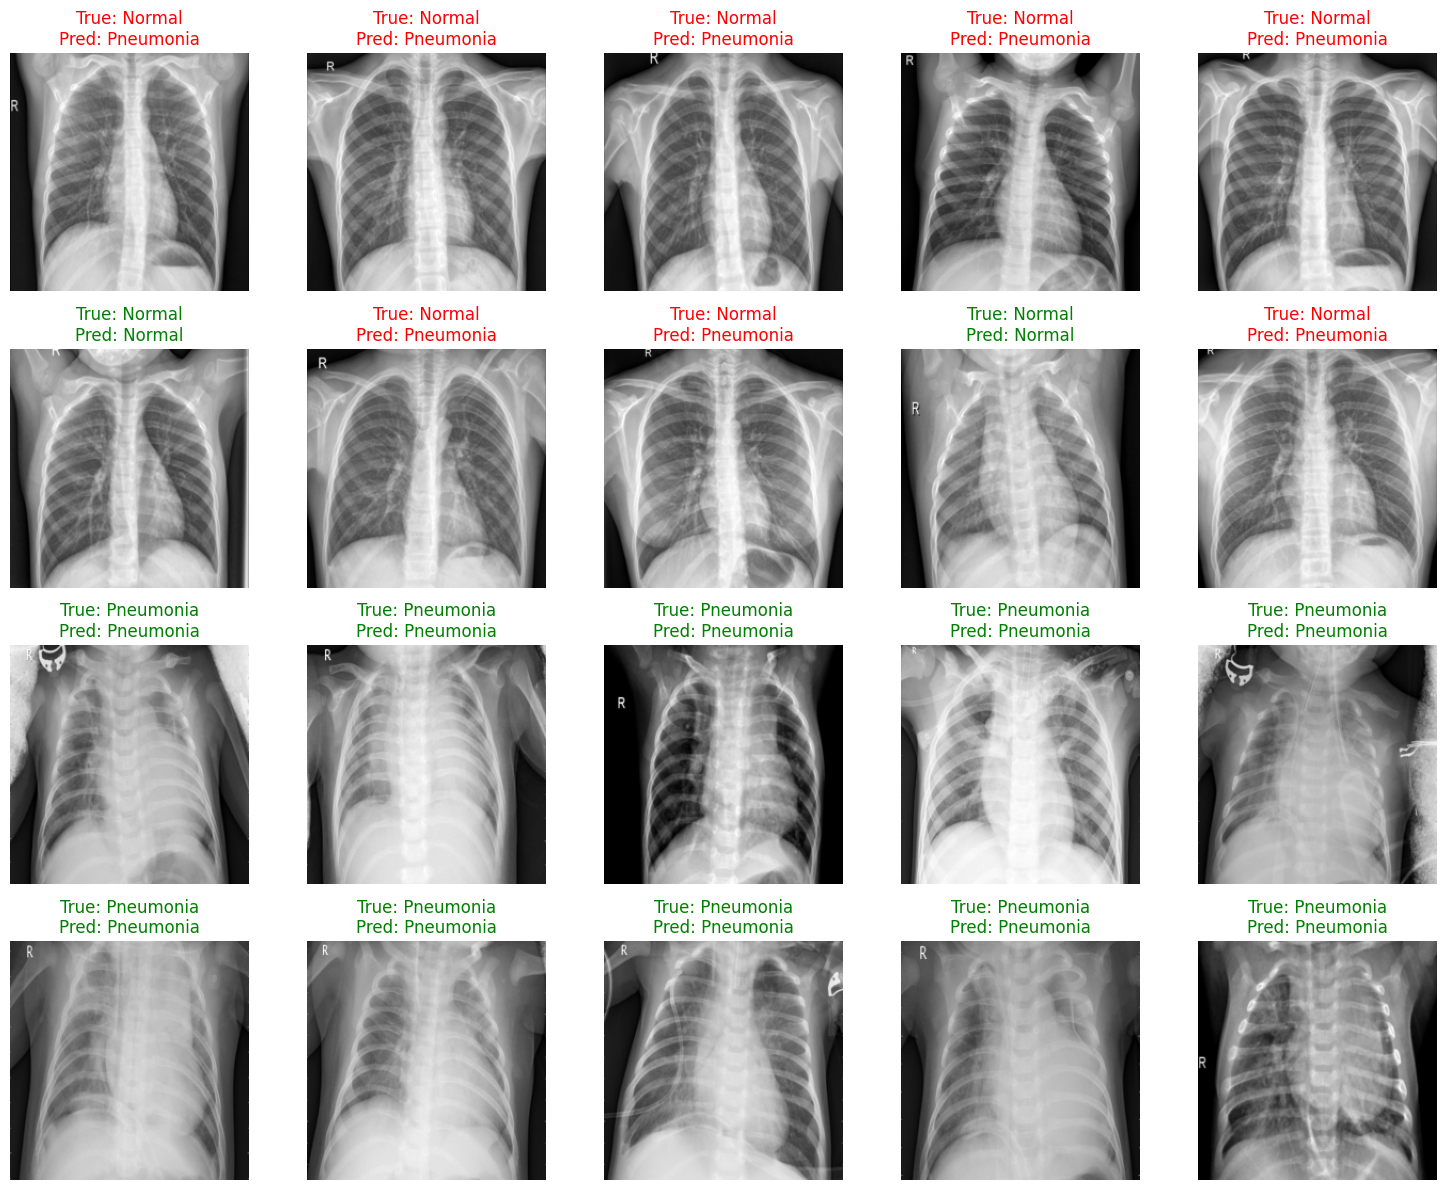

Balanced Predictions from Pretrained ResNet18:


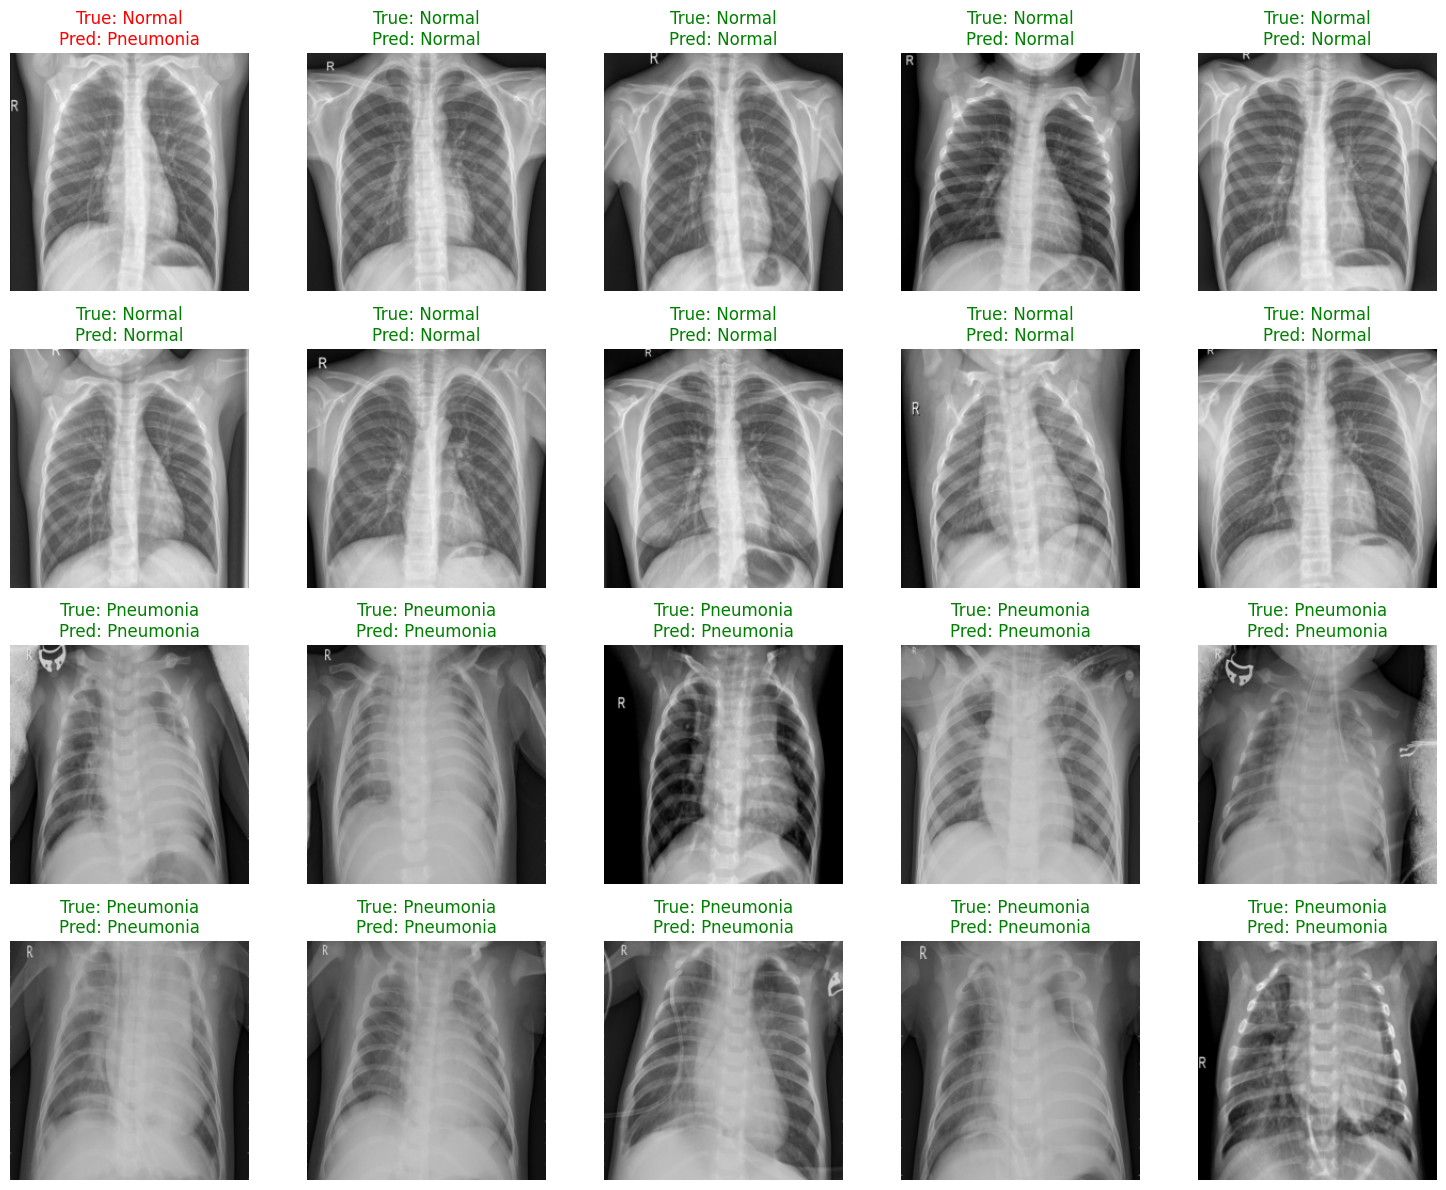

Balanced Predictions from Pretrained VGG:


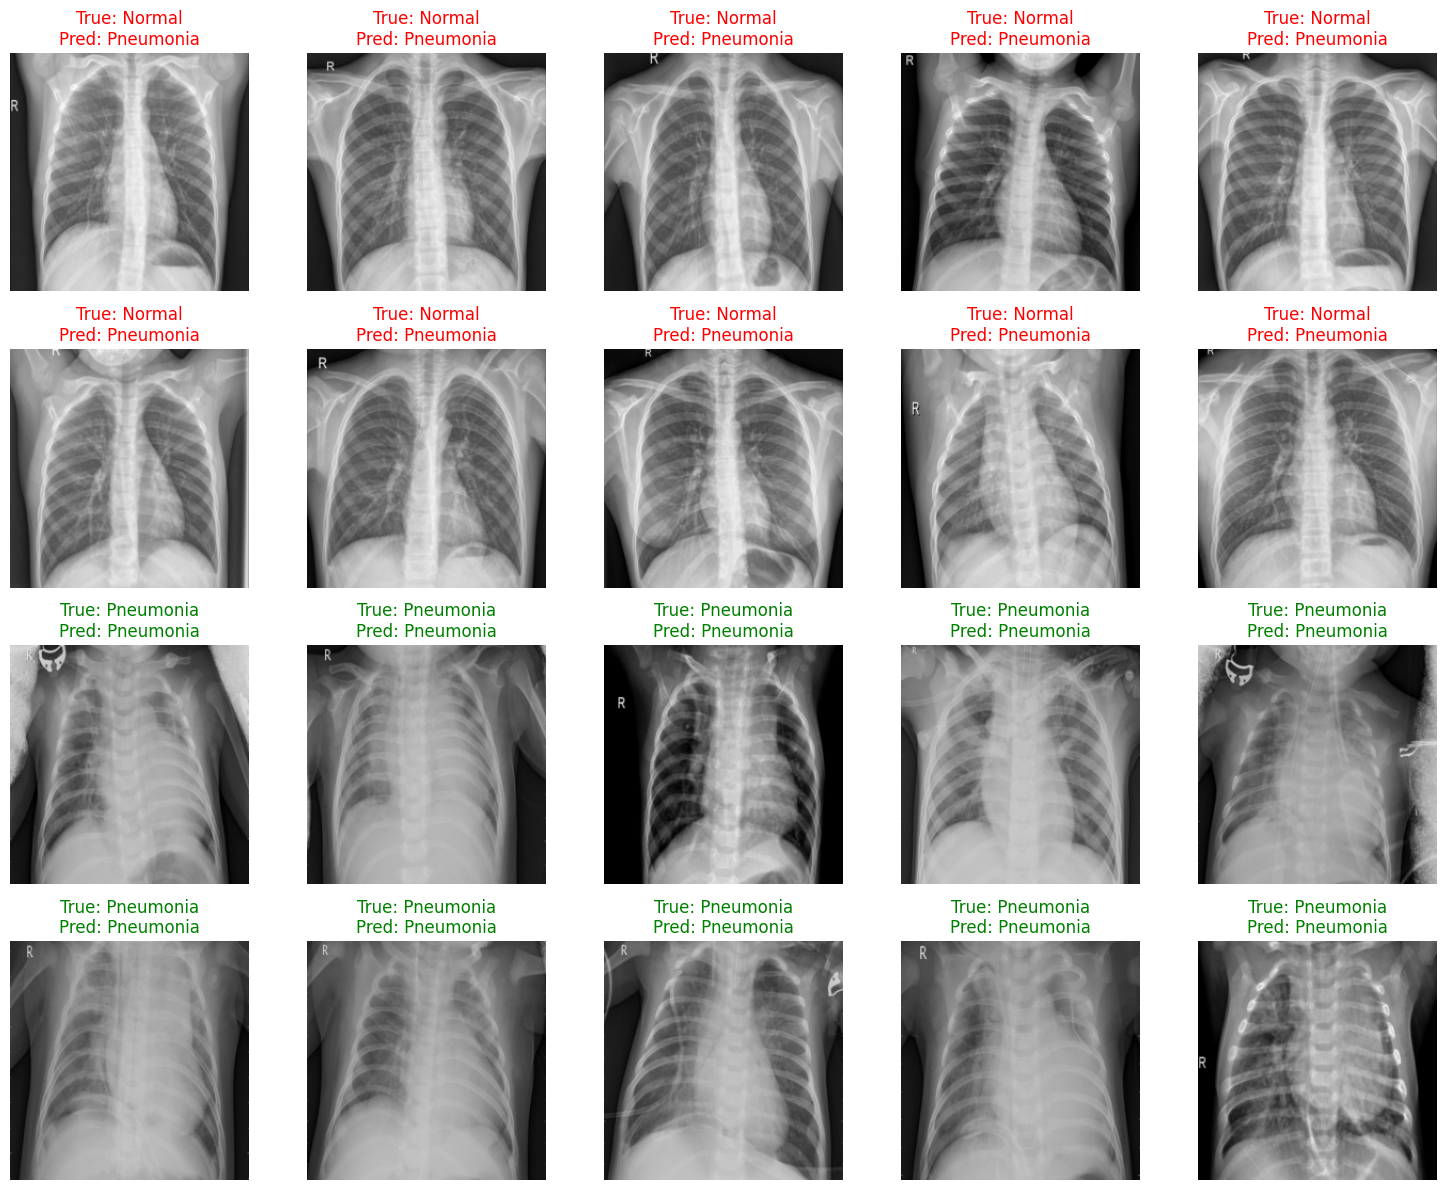

In [ ]:
# Show balanced predictions for Custom CNN
print("Balanced Predictions from Custom CNN:")
show_balanced_predictions(model_from_scratch, test_loader_cnn, class_names=["Normal", "Pneumonia"], num_normal=10, num_pneumonia=10)

# Show balanced predictions for Pretrained ResNet18
print("Balanced Predictions from Pretrained ResNet18:")
show_balanced_predictions(resnet18, test_loader_resnet, class_names=["Normal", "Pneumonia"], num_normal=10, num_pneumonia=10)

# Show balanced predictions for Pretrained VGG
print("Balanced Predictions from Pretrained VGG:")
show_balanced_predictions(vgg16, test_loader_vgg, class_names=["Normal", "Pneumonia"], num_normal=10, num_pneumonia=10)